In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip3 install cython
!pip3 install tables
!pip3 install statsmodels
!pip3 install -q keras
!pip3 install gensim
!pip3 install nltk

In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model, load_model
from keras.layers import Input, CuDNNLSTM, Activation, Lambda, Dense, LeakyReLU, Conv1D,GlobalAveragePooling1D
from keras.layers import Dropout, Bidirectional,Concatenate, BatchNormalization, Flatten
from keras import backend as K, regularizers
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.constraints import maxnorm
from keras.regularizers import l2

In [0]:
ratio = 6
data_dir = 'drive/My Drive/'
data_file = 'drive/My Drive/No_normalized_data.h5'

In [0]:
df = pd.read_hdf(data_file)

In [23]:
df.head()

,claim,num_rev,avg_rat,actualdis,dealdis,timeRem,num_type,recordtime,fixedEffects,day,...,day*avg_rat,dealdis*actualdis,num_type*actualdis,day*actualdis,num_type*dealdis,day*dealdis,day*num_type,deal_id,asin,y
0,0.0,92.0,4.513926,28.387097,31.971326,25178976.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
1,0.0,92.0,4.513926,28.387097,31.971326,21573625.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
2,1.0,92.0,4.513926,28.387097,31.971326,17950233.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
3,2.0,92.0,4.513926,28.387097,31.971326,14338517.0,1.0,3.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
4,3.0,92.0,4.513926,28.387097,31.971326,10708112.0,1.0,3.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1


In [24]:
df.columns
df.shape

(367606, 34)

In [0]:
# f1 = 'y ~ claim + num_rev + avg_rat + actualdis + ' + \
#      'dealdis + timeRem + num_type + C(recordtime) + C(asin) - 1'

# f2 = 'y ~ claim + num_rev + avg_rat + actualdis + ' + \
#      'dealdis + timeRem + num_type + C(recordtime) + C(asin)'

# f3 = 'y ~ claim + num_rev + avg_rat + actualdis + ' + \
#      'dealdis + timeRem + num_type + C(recordtime)'

# f4 = 'y ~ claim*timeRem + claim*dealdis + timeRem*dealdis + timeRem*avg_rat + claim*avg_rat + ' + \
#      'claim + num_rev + avg_rat + actualdis + ' + \
#      'dealdis + timeRem + num_type + C(recordtime) + C(asin)'

# f_list = [f1, f2, f3, f4]
# print(f_list)

In [0]:
def x_value(df, c0_cutoff, c1_cutoff, c2_cutoff, c3_cutoff):

	x = [[]]
	y = []
	x = df.iloc[:, [1, 2, 3, 4, 5, 6, 9\
	 	# 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 \
	 	]].values
	y = df.iloc[:, [0]].values

	y[y <= c0_cutoff] = 0
	y[y > c3_cutoff] = 4
	y[y > c2_cutoff] = 3
	y[y > c1_cutoff] = 2
	y[y > c0_cutoff] = 1
	
	return x, y

In [0]:
def equalSplit(x, y, ratio):

	lenY1 = np.count_nonzero(y == 1)
	lenY2 = np.count_nonzero(y == 2)
	lenY3 = np.count_nonzero(y == 3)
	lenY4 = np.count_nonzero(y == 4)
	lenY0 = len(y) - lenY1 - lenY2 - lenY3 - lenY4

	y0 = y[np.where(y == 0), :][0]
	x0 = x[np.where(y == 0), :][0]
	index = np.random.choice(y0.shape[0], min(ratio*lenY4, lenY0), replace = False)
	x0 = x0[index]
	y0 = y0[index]

	y1 = y[np.where(y == 1), :][0]
	x1 = x[np.where(y == 1), :][0]
	index = np.random.choice(y1.shape[0], min(ratio*lenY4, lenY1), replace = False)
	x1 = x1[index]
	y1 = y1[index]
	
	y2 = y[np.where(y == 2), :][0]
	x2 = x[np.where(y == 2), :][0]
	index = np.random.choice(y2.shape[0], min(ratio*lenY4, lenY2), replace = False)
	x2 = x2[index]
	y2 = y2[index]
	
	y3 = y[np.where(y == 3), :][0]
	x3 = x[np.where(y == 3), :][0]
	index = np.random.choice(y3.shape[0], min(ratio*lenY4, lenY3), replace = False)
	x3 = x3[index]
	y3 = y3[index]

	y4 = y[np.where(y == 4), :][0]
	x4 = x[np.where(y == 4), :][0]
	index = np.random.choice(y4.shape[0], min(ratio*lenY4, lenY4), replace = False)
	x4 = x4[index]
	y4 = y4[index]

	x = np.vstack((x0, x1))
	x = np.vstack((x, x2))
	x = np.vstack((x, x3))
	x = np.vstack((x, x4))
	y = np.vstack((y0, y1))
	y = np.vstack((y, y2))
	y = np.vstack((y, y3))
	y = np.vstack((y, y4))

	return x, y

In [0]:
def StandardModel(numFeatures, Loss, optimizer):

	model = Sequential()
	model.add(Dense(12, input_dim = numFeatures, activation = 'relu'))
	model.add(Dense(8, activation = 'relu'))
	model.add(Dense(5, activation = 'softmax'))
	model.compile(loss = Loss, optimizer = optimizer, metrics = ['accuracy'])
	# model.fit(X, Y, epochs=150, batch_size=10,  verbose=2)
	# predictions = model.predict(X)

In [0]:
def define_model():

	input = Input(shape = INPUT_SHAPE_1, dtype = 'float32', name = 'features')

	x = Dense(75, kernel_regularizer = regularizers.l2(1e-3) ,name = 'Fully_Connected_Layer_1')(input)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_1')(x)

	x = Dense(50, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_2')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_2')(x)

	x = Dense(30, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_3')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_3')(x)

	output = Dense(5, activation = 'softmax', name = 'Fully_Connected_Layer_4')(x)

	model = Model(inputs = [input], outputs = [output], name = 'my_model')

	return model

In [0]:
def run_model(X_train, X_val, Y_train, Y_val, model):

	print(model.summary())
	model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])
	earlystop = EarlyStopping(monitor = 'val_loss', patience = PAT)
	check_pt = ModelCheckpoint(data_dir + 'model_.h5', save_best_only=True)
	callbacks_list = [earlystop, check_pt]

	trained_model = model.fit(X_train, [Y_train], epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, \
								validation_data = [X_val, [Y_val]], callbacks = callbacks_list)

	return trained_model, model

In [0]:
def model_history(trained_model):

	fig, axs = plt.subplots(1,2,figsize=(15,5))

	axs[0].plot(trained_model.history['loss'])
	axs[0].plot(trained_model.history['val_loss'])
	axs[0].set_title('Model Loss')
	axs[0].set_ylabel('Loss')
	axs[0].set_xlabel('Epoch')
	axs[0].legend(['Train', 'Validation'], loc='upper right')

	axs[1].plot(trained_model.history['acc'])
	axs[1].plot(trained_model.history['val_acc'])
	axs[1].set_title('Model Accuracy')
	axs[1].set_ylabel('Accuracy')
	axs[1].set_xlabel('Epoch')
	axs[1].legend(['Train', 'Validation'], loc='upper right')
	plt.show()

x and y created
x and y equally splitted
Train, Validation and test split of x and y

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 7)                 0         
_________________________________________________________________
Fully_Connected_Layer_1 (Den (None, 75)                600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)                300       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75)                0         
_________________________________________________________________
Dropout_Regularization_1 (Dr (None, 75)                0         
_________________________________________________________________
Fully_Connected_Layer_2 (Den (None, 50)                3800      
________________________________________________________

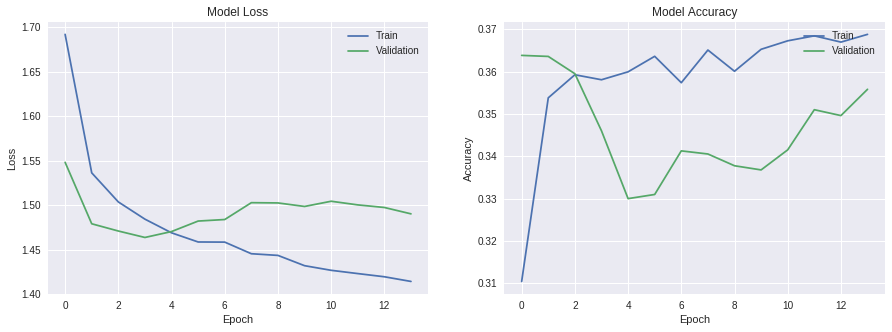

0.36306592879864047


In [39]:
	x, y = x_value(df, 20, 40, 60, 80)
	print('x and y created')
	x, y = equalSplit(x, y, ratio)
	print('x and y equally splitted')

	y = y.astype(int)
	y = np.squeeze(np.eye(5)[y.reshape(-1)])
	x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
	x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=42)
	print('Train, Validation and test split of x and y\n')

	# print('Training started')
	# clf = MLPClassifier()
	# clf.fit(x_train, y_train)

	# print('Testing Started')
	# y_pred = clf.predict(x_train)
	# print('Train Accuracy - ', accuracy_score(y_train, y_pred))
	# y_pred = clf.predict(x_test)
	# print('Test Accuracy - ', accuracy_score(y_test, y_pred))
	# print(len(x_train), len(x_test))

	INPUT_SHAPE_1 = (7,)
	EPOCHS = 50
	BATCH_SIZE = 1024
	DROPOUT = 0.15
	PAT = 10

	K.clear_session()
	model = define_model()
	trained_model, model = run_model(x_train, x_val, y_train, y_val, model)
	model_history(trained_model)
	y_pred = (model.predict(x_train)).argmax(axis=-1)
	y_train = [np.where(r==1)[0][0] for r in y_train]
	print(accuracy_score(y_train, y_pred))

In [0]:
# i = 1

# for f in f_list:
  
#   FE_ols = sm.ols(formula = f, data=df.loc[:50000]).fit()
  
#   with open(data_dir + str(i) + '_asin.txt' , 'w') as myfile:
#     print(FE_ols.summary())
#     myfile.write(str(FE_ols.summary()))
    
#   print("%d Done" % i)
#   i += 1